In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.linalg import lu_factor, lu_solve
import time 

In [3]:
lat_lon_np = pd.read_csv('gs://kriging2/polish_data/polish_data_2023-03-04-17.csv')[['lat', 'lon']].values
altitude_np_arr = pd.read_csv('gs://kriging2/polish_data/polish_data_2023-03-04-17.csv')['temp'].values
grid_df = spark.read.option('header', True).csv('gs://kriging2/polish_data/grid_1920x1080.csv')

In [4]:
grid_rdd = grid_df.rdd.map(lambda x: (int(x[0]), (float(x[1]), float(x[2]))))
n = 8
grid_rdd = grid_rdd.repartition(n)

In [5]:
# altitude_np = np.array([float(x[0]) for x in altitude_np_arr])
altitude_np = altitude_np_arr

In [6]:
lat_lon_np = np.array([(float(x[0]), float(x[1])) for x in lat_lon_np])

### algorithm

<Figure size 640x480 with 0 Axes>

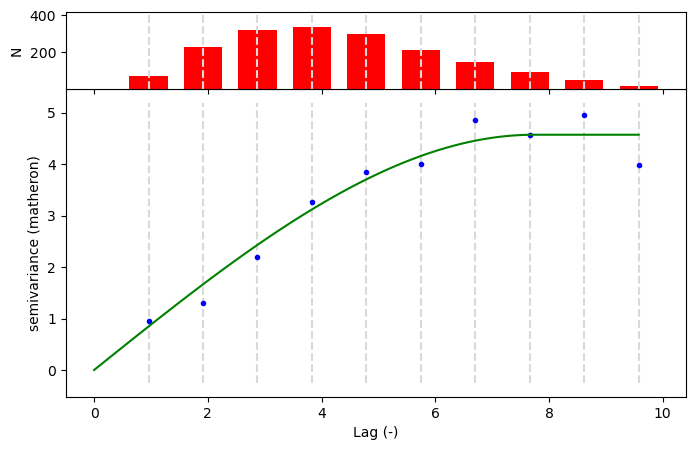

In [7]:
import skgstat as skg
import matplotlib.pyplot as plt

fig = plt.figure()

V = skg.Variogram(coordinates=lat_lon_np, values=altitude_np, n_lags=10, model='spherical')
V.plot()
fig.savefig('./variogram.jpg')
fitted_model = skg.Variogram.fitted_model_function(**V.describe())

In [8]:
V.describe()

{'model': 'spherical',
 'estimator': 'matheron',
 'dist_func': 'euclidean',
 'normalized_effective_range': 74.02168575232649,
 'normalized_sill': 22.621216480235514,
 'normalized_nugget': 0,
 'effective_range': 7.730316015841868,
 'sill': 4.572508665291849,
 'nugget': 0,
 'params': {'estimator': 'matheron',
  'model': 'spherical',
  'dist_func': 'euclidean',
  'bin_func': 'even',
  'normalize': False,
  'fit_method': 'trf',
  'fit_sigma': None,
  'use_nugget': False,
  'maxlag': None,
  'n_lags': 10,
  'verbose': False},
 'kwargs': {}}

In [9]:
def cartesian_product(arr):
    l = len(arr)
    cart = np.empty((l ** 2, 4))
    it = 0
    for x in range(len(arr)):
        p1 = arr[x]
        for y in range(len(arr)):
            p2 = arr[y]
            cart[it] = np.concatenate([p1, p2])
            it += 1
    return cart


def add_bias(covariance_vector):
    covariance_vector = np.array([np.append(x, np.double(1.0)) for x in covariance_vector], dtype=np.double)
    ones = np.ones(len(covariance_vector) + 1, dtype=np.double)
    covariance_vector = np.append(covariance_vector, [ones], axis=0)
    return covariance_vector

In [25]:
import scipy
import time
from scipy.spatial import distance


def fit_transform(lat_lon_np, altitude_np, grid_rdd, fitted_model):
    t1_all = time.time()
    t1_master = time.time()
    matrix_size = len(lat_lon_np)
    cartesian = cartesian_product(lat_lon_np)
    distances = np.array([scipy.spatial.distance.euclidean([x[0], x[1]], [x[2], x[3]]) for x in cartesian])
    covariance = np.array([fitted_model(x) for x in distances])
    covariance_matrix = covariance.reshape(matrix_size, matrix_size)
    covariance_matrix = add_bias(covariance_matrix)
    covariance_matrix[matrix_size, matrix_size] = np.double(0.0)
    
    lu, piv = lu_factor(covariance_matrix)
    t2_master = time.time()
    
    # spark work
    t1_spark = time.time()
    lu_tuple_broadcasted = sc.broadcast((lu, piv))
    
    lat_lon_broadcasted = sc.broadcast(lat_lon_np)
    altitude_broadcasted = sc.broadcast(altitude_np)
    
    def transform(idx_point, fitted_model):
        idx, point = idx_point
        distances_with_unknown_point = np.array(
            [scipy.spatial.distance.euclidean([point[0], point[1]], [x[0], x[1]]) for x in lat_lon_broadcasted.value]
        )
        covariance_vector_unknown = np.array([fitted_model(x) for x in distances_with_unknown_point])
        covariance_vector_unknown = np.append(covariance_vector_unknown, np.double(1.0))
        lu_tuple = lu_tuple_broadcasted.value
        weight_vector = lu_solve(lu_tuple, covariance_vector_unknown)
        weight_vector = weight_vector[:-1]
        prediction = np.dot(weight_vector, altitude_broadcasted.value)
        return (idx, point, prediction)
    
    
    interpolation = grid_rdd.map(lambda idx_point: transform(idx_point, fitted_model)).collect()
    
    t2_spark = time.time()
    t2_all = time.time()
    
    stats = {
        't_spark': t2_spark - t1_spark,
        't_master': t2_master - t1_master,
        't_all': t2_all - t1_all
    }
    
    return (stats, interpolation)

In [26]:
stats, interpolation = fit_transform(lat_lon_np, altitude_np, grid_rdd, fitted_model)

In [30]:
filename = '../grid_1920x1080_inter_spherical.csv'
pd.DataFrame(dataset, columns=['idx', 'lat', 'lon', 'altitude']).to_csv(filename, index=False)